# Applying a Spatial CellTypist Model to Xenium Data

#### **Prerequisites**: 
- A virtual enviroment (eg conda environment) with CellTypist from the Teich Lab installed (refer to [the GitHub](https://github.com/Teichlab/celltypist))
- Preprocessed & segmented Xenium dataset saved as in AnnData format without cell type labels
    - Either nuclear or cell segmentation 
- Pretrained Xenium CellTypist Model (see [this notebook](https://github.com/joadams1/spatial_celltypist/blob/main/notebooks/Training%20Xenium%20CellTypist%20Model.ipynb) or [this notebook]() for details on model training) 

In [1]:
import celltypist as ct
import ast
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns
from tqdm import tqdm
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
import warnings
import json
import sys
import os

#### Model Selection: 
There are some things to note when deciding which model to apply to your dataset. First, the model is constrained to the cell types it was trained on, so if you have other cell types outside of that set that you want to label, you will need to do so manually. In a similar vein, with models trained on Xenium data, it is limited to the genes in the panel of that dataset. It is ideal to have a model that used an extremely similar, if not the exact same, gene panel to the dataset you hope to cell type. The further the genes diverge, the worse model performance will be. Lastly, CellTypist Models work best when applied to datas from similar tissue and organ context. If gene profiles differ significantly, model performance will suffer. All of these points hold true if using a model trained on a downsampled scRNA-seq dataset as well, which the additional caveat that some tissues are more or less suited to this kind of model (using a scRNA-seq model worked on a 10X Lung dataset but not the 10X Colon one).  

For this workflow, I will be using a model trained on a nuclear segmentation of the **10X Xenium Colon** dataset (avaliable [here](https://www.10xgenomics.com/datasets/human-colon-preview-data-xenium-human-colon-gene-expression-panel-1-standard)) that is used in the Segger paper (Heidari, Moorman et al. [*bioRxiv*](https://www.biorxiv.org/content/10.1101/2025.03.14.643160v1) 2025, [GitHub](https://github.com/dpeerlab/segger-analysis/)) and will be applying it to a version of the same data with cellular segmentation. 

In [2]:
## Load everything
data_name = '10x_colon_cell'

filepath_ad = f'/data/peer/adamsj5/spatial_celltypist/data_spatial/{data_name}_processed_clean.h5ad' #replace with your path
ad = sc.read_h5ad(filepath_ad)

filepath_model = '/data/peer/adamsj5/spatial_celltypist/models/10x_colon_nucleus_celltypist_model.pkl'
ct_model = ct.Model.load(str(filepath_model))

## Annotating a dataset
This function uses a CellTypist model to annotate a dataset and also takes care of the necessary preprocessing steps. It requires: 
- `ad`: the dataset you wish to annotate saved as an AnnData object
- `ct_model`: the trained CellTypist model
- `cluster_col`: a column in ad.obs that contains cluster information (run phenograph or leiden to obtain)
- `target_sum`: the number of counts per cell to normalize the data to. Make sure the scale of this data is the same as the data you trained the model on (default: 1000)
- `suffix`: a suffix to append to output columns in ad.obs to differentiate from other CellTypist outputs (if you train with several different modelsfor example). Can be left empty

The cluster information is used in the optional 'majority voting' step in CellTypist annotation. Basically, once CellTypist has assigned a cell type to every cell, it groups cells by cluster. If more than some threshold of cells in that cluster share the same cell type, then that entire cluster will be relabelled as that cell type. The original cell labels are still shared as an output, but this provides an additional, more cohesive annotation. 

In [3]:
def annotate_cell_types(
    ad: sc.AnnData,
    ct_model: ct.Model,
    cluster_col: str = 'phenograph_cluster',
    target_sum: int = 1000,
    suffix: str = None,
):
    # Re-normalize consistent with CellTypist model
    t = target_sum
    ad.layers[f'norm_{t}'] = ad.raw.X.copy()
    sc.pp.normalize_total(ad, layer=f'norm_{t}', target_sum=t)
    ad.layers[f'lognorm_{t}'] = ad.layers[f'norm_{t}'].copy()
    if 'log1p' in ad.uns: del ad.uns['log1p']
    sc.pp.log1p(ad, layer=f'lognorm_{t}')
    
    # Cell type
    ad.X = ad.layers[f'lognorm_{t}']
    preds = ct.annotate(
        ad, model=ct_model, majority_voting=True,
        over_clustering='phenograph_cluster',
        min_prop=0.2,
    )
    
    # Label AnnData
    suffix = '' if suffix is None else f'_{suffix}'
    ad.obs[f'celltypist_label{suffix}'] = preds.predicted_labels['predicted_labels']
    ad.obs[f'celltypist_label_cluster{suffix}'] = preds.predicted_labels['majority_voting']
    ad.obs[f'celltypist_probability{suffix}'] = preds.probability_matrix.max(1)
    for col in preds.probability_matrix.columns:
        ad.obs[f'{col}_probability'] = preds.probability_matrix[col]
    entropy = sp.stats.entropy(preds.probability_matrix, axis=1)
    ad.obs[f'celltypist_entropy{suffix}'] = entropy
    
    # Cleanup
    del ad.layers[f'lognorm_{t}'], ad.layers[f'norm_{t}']

In [4]:
## annotate the dataset
annotate_cell_types(ad, ct_model, cluster_col='phenograph_cluster', target_sum=100)

⚠️ Warning: invalid expression matrix, expect ALL genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 260232 cells and 425 genes
🔗 Matching reference genes in the model
🧬 425 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


## Visualization
Now that you have an annotated dataset, you can visualize the data using cell type labels. You can do this using the per-cell level annotations: 

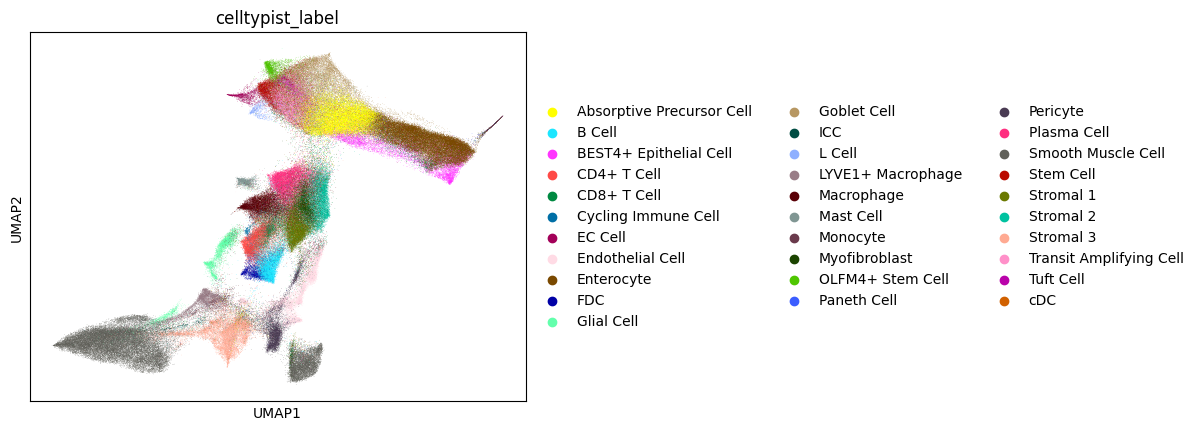

In [5]:
sc.pl.umap(ad, color = 'celltypist_label')

And you can do this using the cluster level annotations (some of the rare cell populations have been lost using this annotation level): 

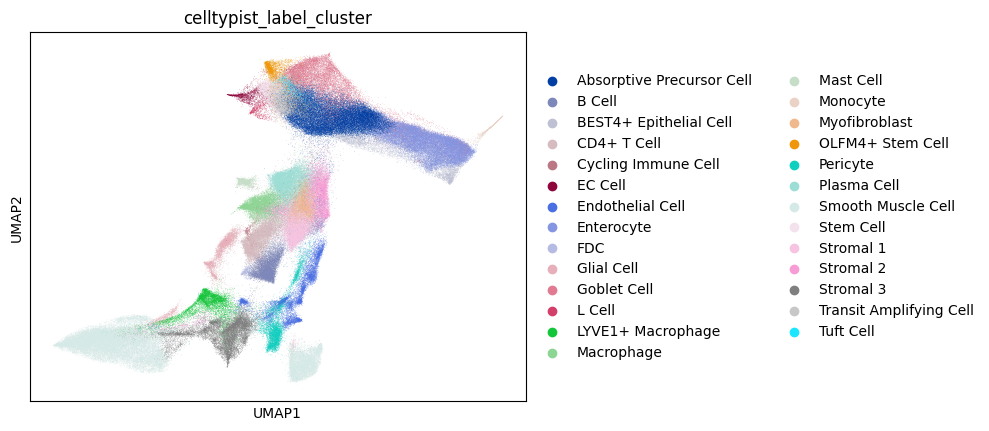

In [6]:
sc.pl.umap(ad, color = 'celltypist_label_cluster')

Additionally, a nice facet of using CellTypist to annotate is it gives a per-cell prediction score that quantifies how confident the model is in each cell's annotation. This allows you, the user, to identify any "problem populations" and manually reassess and, potentially re-cell-type, low confidence cells. A score of 1 means the model confidence, and a score of 0 is practically random guessing. 

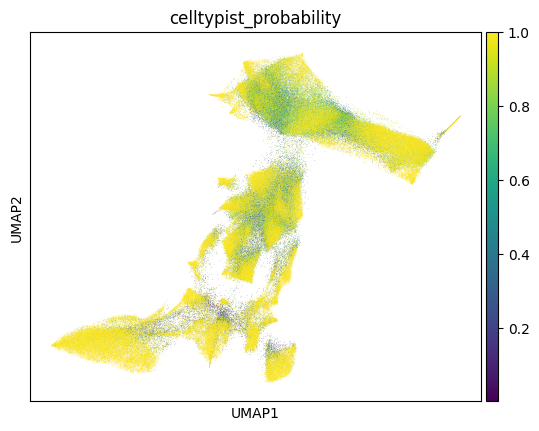

In [7]:
sc.pl.umap(ad, color = 'celltypist_probability')

The function above also computes cell type entropy. For each cell, CellTypist gives a probability score for each cell type which captures how likely it thinks that cell belongs to every cell type. This entropy score quantifies this matrix of probability scores, so in a similar way to the CellTypist confidence score, this value captures model uncertainty in prediction (with an inverse metric - high scores here are lower confidence). 

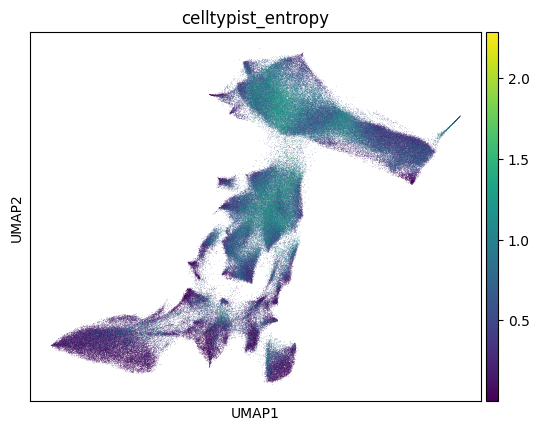

In [8]:
sc.pl.umap(ad, color = 'celltypist_entropy')

Lastly, if you have a more coarse labelling of these cell types, you can apply this to your dataset. You can do this either by creating a mapping from fine  to coarse labels or by training another model. For this you would need to either manually create a higher-level set of cell annotations, or have the original data/marker genes list that the model was trained on that already contains this more coarse mapping. 

In [9]:
filepath_mark = '../data_spatial/cell_type_markers.csv' # replace with your own path
markers = pd.read_csv(filepath_mark, index_col=0)

# Compartment by cluster
col = 'group'
cp_map = markers.dropna().set_index(col)['compartment']
cp_map = cp_map[~cp_map.index.duplicated()]

ad.obs['celltypist_label_coarse'] = ad.obs['celltypist_label_cluster'].map(cp_map)

... storing 'celltypist_label_coarse' as categorical


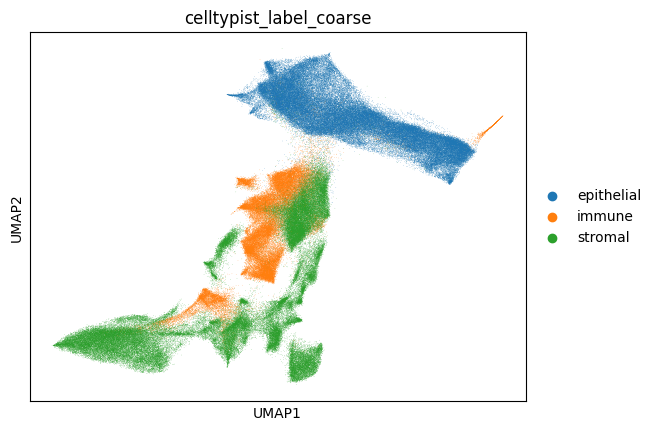

In [10]:
sc.pl.umap(ad, color = 'celltypist_label_coarse')

Remember to save your annotated dataset, and thats it.

In [11]:
filepath_final = f'../data_spatial/{data_name}_celltyped.h5ad' #replace with your own path
ad.write_h5ad(filepath_final)

For an explanation of additional basic analysis steps, visit the notebook [`Basic Analysis of Xenium Data`](https://github.com/joadams1/spatial_celltypist/blob/main/notebooks/Basic%20Analysis%20of%20Xenium%20Data.ipynb). 